In [2]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt

In [3]:
def fuck_bsas(X, theta, q, order):
    [l, N] = X.shape
    n_clust = 1

    if (len(order) == 0):
        order = np.matrixlib.mat(range(N))
    bel = np.matlib.zeros((1, N), dtype=np.int)
    
    bel[0, order[0,0]] = n_clust
    repre = X[:, order[0,0]]
    
    for i in np.arange(1, N):
        [m1, m2] = repre.shape
        
        tmp = repre - X[:, order[0,i]] * np.matlib.ones((1, m2), dtype=np.double)
        tmp = np.sqrt(np.sum(np.square(tmp), axis=0))
        #print(tmp)
        s2 = np.unravel_index(tmp.argmin(), tmp.shape)
        #print(s2)
        s1 = tmp[s2]        
        if ((s1 > theta) & (n_clust < q)):
            n_clust+=1
            bel[0, order[0,i]] = n_clust
            repre = np.concatenate((repre, X[:, order[0,i]]), axis=1)
        else:
            bel[0, order[0,i]] = s2[1]+1
            tmp = np.sum(np.equal(bel, s2[1]+1), dtype=np.double)
            #print ("new repre pt.0: ",tmp)
            repre[:, s2[1]] = np.divide(( (tmp - 1)*repre[:, s2[1]] + X[:, order[0,i]] ), tmp)
            #print ("new repre pt.1: ", (( (tmp - 1)*repre[:, s2[1]] + X[:, order[0,i]] )))
            #print ('new repre pt.2: ', repre[:, s2[1]])
    return bel, repre

In [124]:
def screw_bsas (X, n_theta=50, n_times=10):
    #Determine the minimum and the maximum distances between points of X
    [l, N] = X.shape
    dista = np.matlib.zeros((N, N), dtype=np.int)
    Y = X.copy()
    for i in np.arange(N):
        for j in np.arange(2,N):
            dista[i,j] = np.sqrt(np.sum(np.square(X[:,i]-X[:,j]), axis=0))
            dista[j,i] = dista[i,j]
    
    #print(dista)
    true_maxi = dista.max()
    true_mini = dista.min()
    
    #Determine theta_min, theta_max, and s by typing
    meani = (true_mini+true_maxi)/2.0
    theta_min=0.25*meani
    theta_max=1.75*meani
    s=(theta_max-theta_min)/(n_theta-1)
    
    #Run BSAS ntimes for all values of theta, each time with a different ordering of the data
    q=N
    m_tot = []
    for theta in np.arange(theta_min, theta_max+s, s):
        list_m = np.matlib.zeros((1, q), dtype=np.int)
        for stat in np.arange(n_times):
            order = np.matrix(np.random.permutation(N))
            [bel, m] = fuck_bsas(X, theta, q, order)
            list_m[0,m.shape[1]] += 1
        m_size = [np.unravel_index(list_m.argmax(), list_m.shape)[1]]
        m_tot = m_tot + m_size
    m_tot = np.matrix(m_tot)
    
    #Plot m_theta versus theta
    theta_tot = np.matrix(np.arange(theta_min, theta_max+s, s))
    plt.figure(figsize=(10, 10))
    plt.plot(theta_tot, m_tot, 'bx-') 
    plt.xlabel('theta_tot')
    plt.ylabel('m_tot')
    plt.title('m_theta versus theta')
    plt.grid()
    plt.show()    
    
    #Determine the final estimate of the number of clusters and the corresponding theta
    m_best = 0
    theta_best = 0
    siz = 0
    
    for i in range(m_tot.shape[1]):
        if (m_tot[0,i] != 1):
            t = m_tot-m_tot[0,i]
            siz_temp = np.sum(np.equal(t, 0), axis=1)
            if (siz < siz_temp):
                siz = siz_temp
                theta_best = np.sum(np.multiply(theta_tot, np.equal(t, 0)), axis=0, dtype=np.double)/siz_temp
                m_best = m_tot[0,i];
        if(np.sum(np.equal(m_tot, m_best), axis=1) < np.multiply(n_theta, 1)):
            m_best=1;
            theta_best=np.sum(np.multiply(theta_tot, np.equal(m_tot, 1)), axis=1, dtype=np.double)/np.sum(np.equal(m_tot, 1),axis=1);
            
    order = np.matrix(np.random.permutation(N))
    print ('theta_best: ', theta_best)
    [bel, repre] = fuck_bsas(Y, theta_best, q, order);

    return [bel, repre]

In [142]:
def clust_reassign(X, repre, bel):
    [l, N] = X.shape
    [l, n_clust] = repre.shape
    new_bel = bel
    
    for i in range(N):
        tmp = X[:, i] * np.matlib.ones((1, n_clust), dtype=np.double) - repre
        tmp = np.sqrt(np.sum(np.square(tmp), axis=0))
        q2 = np.unravel_index(tmp.argmin(), tmp.shape)
        q1 = tmp[q2]   
        new_bel[0, i] = q2[1]+1
    
    new_repre = np.matlib.zeros((l, n_clust), dtype=np.double)
    for j in range(n_clust):
        new_repre[:, j] = np.sum( X[np.where(bel == j+1)].T ).T / np.sum(np.equal(bel, j+1),axis=1);
    
    return [new_bel, new_repre]

In [125]:
X = np.matrix('2 5; 6 4; 5 3; 2 2; 1 4; 5 4; 3 3; 2 3; 2 4; 8 2; 9 2; 10 2; 11 2; 10 3; 9 1', dtype=np.double); X= X.T
q = 15; theta = 2.5
order = np.matrix('8 6 11 1 5 2 3 4 7 10 9 12 13 14 15')
order = order - np.matlib.ones_like(order, dtype=np.int)

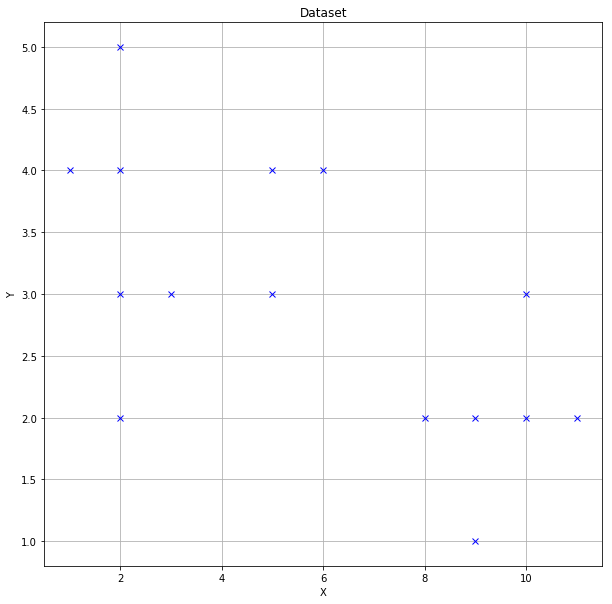

In [221]:
plt.figure(figsize=(10, 10))
plt.plot(X[0,:], X[1,:], 'bx-')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Dataset')
plt.grid()
plt.show()  

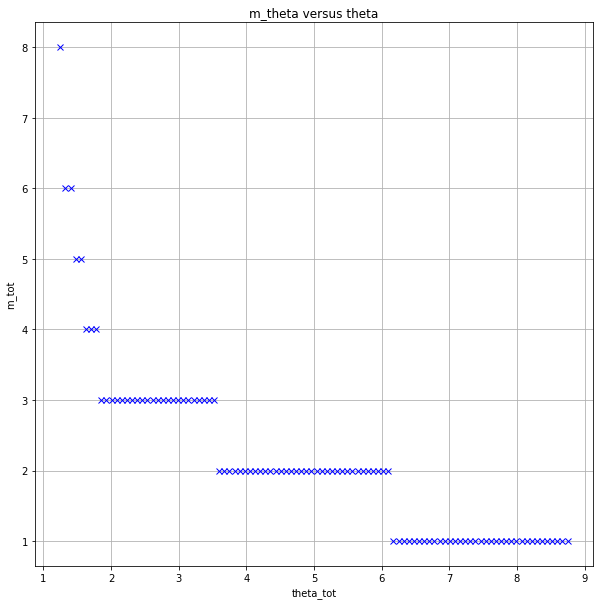

theta_best:  [[ 7.46212121]]
Clustering Labels:  [[1 1 1 1 1 1 1 1 1 2 2 2 2 2 2]]
Centroids:  [[ 3.11111111  9.5       ]
 [ 3.55555556  2.        ]]


In [144]:
[bel_new, repre_new] = screw_bsas(X.copy(), n_theta=100, n_times=30)
print("Clustering Labels: ", bel_new)
print("Centroids: ", repre_new)

In [145]:
[bel_opt, repre_opt] = clust_reassign(X.copy(), repre_new.copy(), bel_new.copy())
print("[Optimal] Clustering Labels: ", bel_new)
print("[Optimal] Centroids: ", repre_new)

[Optimal] Clustering Labels:  [[1 1 1 1 1 1 1 1 1 2 2 2 2 2 2]]
[Optimal] Centroids:  [[ 3.11111111  9.5       ]
 [ 3.55555556  2.        ]]


# Experiments

In [7]:
[bel_2, repre_2] = fuck_bsas(X, 3, q, order)

In [8]:
bel_2

matrix([[1, 2, 2, 1, 1, 2, 1, 1, 1, 3, 3, 3, 3, 3, 3]])

In [9]:
repre_2

matrix([[ 2.        ,  5.33333333,  9.5       ],
        [ 3.5       ,  3.66666667,  2.        ]])